## Jaynes-Cummings Hamiltonian (RWA)
$$H = \hbar \omega_c \hat{a}^\dagger \hat{a} + \frac12 \hbar \omega_a \hat{\sigma}_z + \frac12 \hbar \Omega \left( \hat{a}^{\dagger}\hat{\sigma}_- + \hat{a}\hat{\sigma}_+ \right)$$

https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model#Jaynes%E2%80%93Cumming_Hamiltonian_1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.linalg import expm
from scipy.sparse import kron, eye, diags, csr_matrix
from scipy.sparse.linalg import spsolve, expm
from scipy.integrate import cumtrapz

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 18})

In [23]:
# Parameters
ħ = 1
ω_c = 1.5 
ω_a = 1 
Ω = 2

#Atom basis 
g = np.array([1,0]); g.shape = (2,1)
e = np.array([0,1]); e.shape = (2,1)
Sz = csr_matrix(np.outer(g,g) - np.outer(e,e))
Sp = csr_matrix(np.outer(e,g))
Sm = csr_matrix(np.outer(g,e))
I_a = np.outer(e,e) + np.outer(g,g)

#Light basis
N = 2500
I_l = eye(N)
coefs = np.array([np.sqrt(i) for i in range(1,N)])
a_dagger = diags(coefs,offsets=-1)
a = a_dagger.transpose()
n = a_dagger.dot(a)

#Hamiltonian
H = ħ*ω_c*kron(I_a,n) + 0.5*ħ*ω_a*kron(Sz,I_l) + 0.5*ħ*Ω*(kron(Sm,a_dagger) + kron(Sp,a))

#Initial conditions
Light_init = np.full((N,1),1/np.sqrt(N-1)); Light_init[-1] = 0 
ψ_init_e = np.kron(e,Light_init)
ψ_init_g = np.kron(g,Light_init)

## Amplitudes
The initial state of the atom is 
$$|\psi_a\rangle = \alpha |g\rangle + \beta |e\rangle$$
The initial state of the EM field is 
$$|\psi_l (t=0) \rangle = \sum_k C_k |k\rangle$$
The total initial condition is 
$$|\Psi(t=0)\rangle = |\psi_a\rangle |\psi_l (t=0) \rangle = \sum_k C_k \alpha |g\rangle |k\rangle + \sum_k C_k \beta |e\rangle |k\rangle$$
The evolution is given by 
$$U(t) = e^{-i/ \hbar H t }$$
Such that
$$|\Psi(t)\rangle = U(t) |\Psi(t=0)\rangle$$
This state can be written as 
$$|\Psi(t)\rangle = \begin{pmatrix} \alpha(t) \\ \beta(t) \end{pmatrix} \otimes \begin{pmatrix} C_0(t) \\ \vdots \\ C_N(t) \end{pmatrix} = \begin{pmatrix} \alpha(t) C_0(t) \\ \vdots \\ \alpha(t)  C_N(t) \\ \beta(t) C_0(t) \\ \vdots \\ \beta(t)  C_N(t) \end{pmatrix} $$
Therefore, 
$$P_{|g\rangle}(t) = |\alpha(t)|^2 \sum_{k=0}^{N} |C_k|^2 = |\alpha(t)|^2  $$
$$P_{|e\rangle}(t) = |\beta(t)|^2 \sum_{k=0}^{N} |C_k|^2 = |\beta(t)|^2  $$

0.005025125628140704


Text(0.5, 0, 'Time')

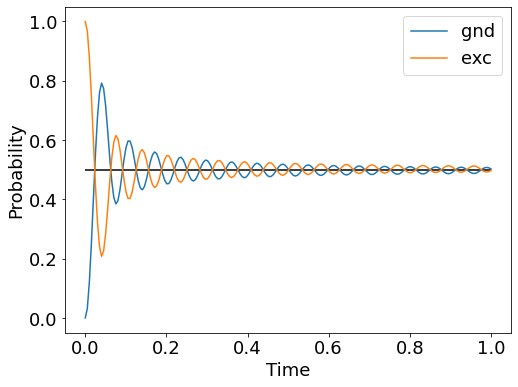

In [24]:
timesteps = 200
tf = 1
t = np.linspace(0,tf,timesteps)
Pg = np.zeros((timesteps,1))
Pe = np.zeros((timesteps,1))

δt = t[1]-t[0]
print(δt)

δU = expm((-1j/ħ)*δt*H)

α = 0
β = np.sqrt(1-np.abs(α)**2)
ψ = α*ψ_init_g + β*ψ_init_e 
Pg[0], Pe[0] = np.sum(np.power(np.abs(ψ[0:N]),2)), np.sum(np.power(np.abs(ψ[N:-1]),2))

for i in range(1,timesteps):
    ψ = δU.dot(ψ)
    Pg[i], Pe[i] = np.sum(np.power(np.abs(ψ[0:N]),2)), np.sum(np.power(np.abs(ψ[N:-1]),2))
    
plt.plot(t,Pg,'-') 
plt.plot(t,Pe,'-')
plt.legend(["gnd","exc"])
plt.hlines(0.5,0,tf,colors="black")
plt.ylabel('Probability')
plt.xlabel('Time')

## Trace distance

Let $\rho_g$ and $\rho_e$ be the density matrices of the atom initially at the ground and excited state, respectively. The trace distance is defined as 

$$D(\rho_e,\rho_g) = \frac12 \text{Tr} |\rho_e-\rho_g| = \frac12 \text{Tr} \sqrt{\rho_e^{\dagger}\rho_g}$$

https://arxiv.org/abs/0908.0238

To obtain the reduced density matrices, we must trace over the field states

$$\rho_{\psi_a} = \text{Tr}_{\psi_l} |\Psi \rangle \langle \Psi| = \sum_k \mathrm{I}_a \otimes \langle k| \left( | \Psi \rangle \langle \Psi| \right) \mathrm{I}_a \otimes| k \rangle $$

$$\rho_{\psi_a}(t)  = \sum_k \mathrm{I}_a \otimes \langle k| \, \rho(t) \, \mathrm{I}_a \otimes| k \rangle $$

$$\rho_{\psi_a}(t)  = \mathrm{I}_a \otimes \begin{pmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix}  \, \rho(t) \, \mathrm{I}_a \otimes \begin{pmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix} + \mathrm{I}_a \otimes \begin{pmatrix} 0 \\ 1 \\ \vdots \\ 0 \end{pmatrix}  \, \rho(t) \, \mathrm{I}_a \otimes \begin{pmatrix} 0 \\ 1 \\ \vdots \\ 0 \end{pmatrix} + \cdots + \mathrm{I}_a \otimes \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{pmatrix}  \, \rho(t) \, \mathrm{I}_a \otimes \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{pmatrix} $$

$$\rho_{\psi_a}(t) = \begin{pmatrix} \rho_{00} & \rho_{0n} \\ \rho_{n0} & \rho_{nn} \end{pmatrix} +  \begin{pmatrix} \rho_{11} & \rho_{1 \,n+1} \\ \rho_{n+1 \,1} & \rho_{n+1\,n+1} \end{pmatrix} + \cdots +  \begin{pmatrix} \rho_{n-1 \, n-1} & \rho_{n-1 \,2n-1} \\ \rho_{2n-1 \, n-1} & \rho_{2n-1\,2n-1} \end{pmatrix}$$

$$\rho_{\psi_a}(t) = \begin{pmatrix} \sum_{k=0}^{n-1} \rho_{ii} & \sum_{k=0}^{n-1} \rho_{i \,i+n}  \\  \sum_{k=0}^{n-1} \rho_{i+n \,i} & \sum_{k=0}^{n-1} \rho_{i +n \,i+n}   \end{pmatrix}$$

/home/alejandro/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/alejandro/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/home/alejandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Trace distance')

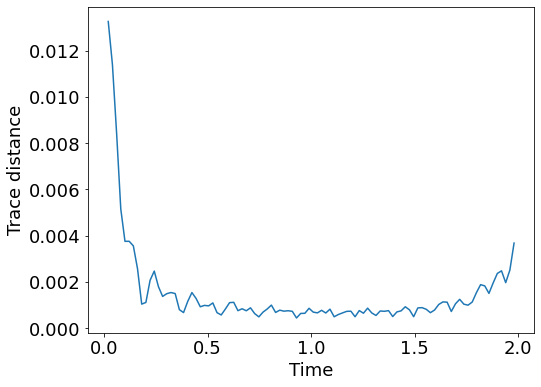

In [25]:
timesteps = 100
tf = 2
t = np.linspace(0,tf,timesteps)
δt = t[1]-t[0]

D = np.zeros((timesteps,1),dtype='complex')
δU = expm((-1j/ħ)*δt*H)

ψ_g = csr_matrix(ψ_init_g) 
ψ_e = csr_matrix(ψ_init_e) 

def reduce_density_matrix(ρ,N):
    ρ_red = np.zeros((2,2),dtype='complex')
    ρ_red[0,0] = ρ.diagonal(k=0)[0:N].sum()
    ρ_red[0,1] = ρ.diagonal(k=N).sum()
    ρ_red[1,0] = ρ.diagonal(k=-N).sum()
    ρ_red[1,1] = ρ.diagonal(k=0)[N:-1].sum()
    return ρ_red
    
for i in range(1,timesteps):
    ψ_e = δU.dot(ψ_e)
    ψ_g = δU.dot(ψ_g)
    ρ_e = ψ_e.dot(ψ_e.transpose())
    ρ_g = ψ_e.dot(ψ_g.transpose())
    ρ_e_red = reduce_density_matrix(ρ_e,N)
    ρ_g_red = reduce_density_matrix(ρ_g,N)
    D[i] = np.sqrt(np.dot( (ρ_e_red-ρ_g_red).conj().T , (ρ_e_red-ρ_g_red) )).trace()
    
plt.plot(t[1:-1],D[1:-1],'-')
plt.xlabel('Time')
plt.ylabel('Trace distance')

## Trace distance rate

The trace distance rate is defined as 

$$\sigma_d = \frac12 \frac{d}{dt} D(\rho_e,\rho_g)$$

https://arxiv.org/abs/0908.0238


/home/alejandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Trace rate')

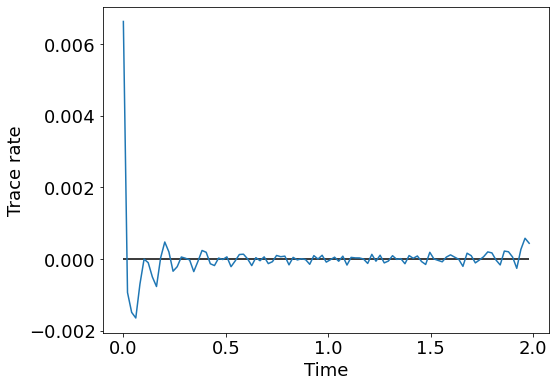

In [26]:
σ = np.diff(D.flatten())/2    
tp = t[0:timesteps-1]
plt.plot(tp,σ,'-')
plt.hlines(0,tp[0],tp[-1],'k')
plt.xlabel('Time')
plt.ylabel('Trace rate')


## Markovianity counter

A measure of the non-markovianity is

$$\mathcal{N} = \max_{\rho_{e,g}} \int_{\sigma_d>0} \sigma_{d} dt$$

https://arxiv.org/abs/0908.0238


/home/alejandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Markovianity counter')

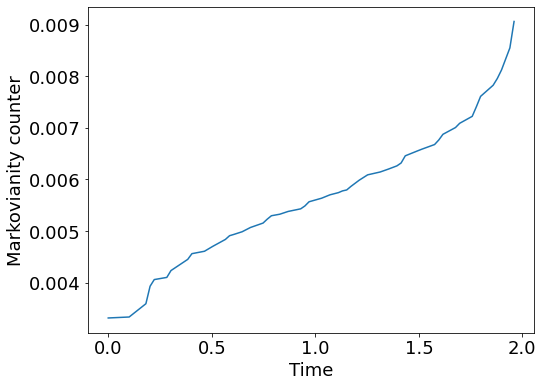

In [27]:
σ_r = σ[σ>0]
t_r = tp[σ>0]
N = cumtrapz(σ_r)

plt.plot(t_r[0:-1],N)
plt.xlabel('Time')
plt.ylabel('Markovianity counter')